In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import os
import CRPS.CRPS as pscore

In [416]:
files = []
PATH = "/Users/marron31/repos/bcm4rcm/data/processed"
for file in os.listdir(PATH):
    if file.endswith(".csv"):
        if '1976' in file:
            files.append(os.path.join(PATH, file))
            
files

['/Users/marron31/repos/bcm4rcm/data/processed/historical_MPI-REMO2009_1976_2006.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_CSIRO_1976_2006.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_MPI_IITM_1976_2006.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_NOAA_SMHI1976_2006.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_MIROC_1976_2006.csv']

In [418]:
def aggregate_to_4d_array(df, agg_func='mean'):
    """
    Aggregates values from a DataFrame for each month, latitude, longitude, and year,
    then reshapes the result into a 4D NumPy array.
    
    Parameters:
    - df: Pandas DataFrame with columns ['time', 'lat', 'lon', 'tp']
    - agg_func: String name of the aggregation function to use (e.g., 'mean', 'sum')
    
    Returns:
    - A 4D NumPy array with shape [12, 90, 40, -1], where -1 is the number of years
    """
    # Ensure 'time' is a datetime type
    df['time'] = pd.to_datetime(df['time'])
    
    # Extract month and year
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year - df['time'].dt.year.min()  # Normalize year
    
    # Group and aggregate
    aggregated_df = df.groupby(['month', 'lat', 'lon', 'year'])['tp'].agg(agg_func).reset_index()
    
    # Pivot
    pivoted_df = aggregated_df.pivot_table(index=['month', 'lat', 'lon'], columns='year', values='tp', fill_value=0)
    
    # Convert to a 4D array and reshape
    num_years = len(df['year'].unique())
    result_array = pivoted_df.values.reshape((12, 90, 40, num_years))
    
    return result_array

# Example usage:
# Assuming your DataFrame is named df and has the required columns
# result_array = aggregate_to_4d_array(df, agg_func='mean')
# Now result_array is the desired 4D array


In [419]:
rcm_dict = {}
for file in files:
    df = pd.read_csv(file)
    df = aggregate_to_4d_array(df)
    rcm_dict[file.split('/')[-1].split('_')[1]] = df

In [420]:
for k,v in rcm_dict.items():
    print(k, v.shape)

MPI-REMO2009 (12, 90, 40, 30)
CSIRO (12, 90, 40, 12)
MPI (12, 90, 40, 30)
NOAA (12, 90, 40, 30)
MIROC (12, 90, 40, 30)


In [421]:
weights_path = "/Users/marron31/repos/bcm4rcm/data/weights/wass_arr.npy"
weights_arr = np.load(weights_path)

weights_arr = (weights_arr/weights_arr.sum(axis=0))*100

In [410]:
# stack each memeber of rcm_dict into a 5D array
rcm_5d = np.stack(list(rcm_dict.values()), axis=0)

ValueError: all input arrays must have the same shape

In [402]:
print(rcm_5d.shape, weights_arr.shape)
kde_results = np.zeros((12, 90, 40), dtype=object)

for i in range (12):
    for j in range (90):
        for k in range (40):
            temp_array = np.array([])
            for r in range (5):
                # print(rcm_5d[r,i,j,k,:].shape, weights_arr[r,i,j,k,0])
                repeat_array = rcm_5d[r,i,j,k,:].repeat(weights_arr[r,i,j,k,0])
                temp_array = np.append(temp_array, repeat_array)
                # kde of temp array
            # apply log transformation to temp_array
            temp_array = log_transform(temp_array)
            temp_kde = gaussian_kde(temp_array)
            kde_results[i,j,k] = temp_kde
            print(i,j,k)
            # rcm_5d[:,i,j,k,:] = rcm_5d[:,i,j,k,:] * weights_arr[:,i,j,k]


(5, 12, 90, 40, 15) (5, 12, 90, 40, 1)
0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
0 0 39
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 1 20
0 1 21
0 1 22
0 1 23
0 1 24
0 1 25
0 1 26
0 1 27
0 1 28
0 1 29
0 1 30
0 1 31
0 1 32
0 1 33
0 1 34
0 1 35
0 1 36
0 1 37
0 1 38
0 1 39
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 2 15
0 2 16
0 2 17
0 2 18
0 2 19
0 2 20
0 2 21
0 2 22
0 2 23
0 2 24
0 2 25
0 2 26
0 2 27
0 2 28
0 2 29
0 2 30
0 2 31
0 2 32
0 2 33
0 2 34
0 2 35
0 2 36
0 2 37
0 2 38
0 2 39
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 3 11
0 3 12
0 3 13
0 3 14
0 3 15
0 3 16
0 3 17
0 3 18
0 3 19
0 3 20
0 3 21
0 3 22


In [57]:
weights_dict = {}
for k,v in rcm_dict.items():
    weights_dict[k] = np.round(np.random.rand(1),2)

In [58]:
for k,v in rcm_dict.items():
    v = np.repeat(v, int(weights_dict[k]*100), axis=3)
    rcm_dict[k] = v

/var/folders/20/mmwsmqln50jb9dbszgvt2l240000gp/T/ipykernel_95145/1660977929.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = np.repeat(v, int(weights_dict[k]*100), axis=3)


In [59]:
for k,v in rcm_dict.items():
    print(v.shape)

(12, 90, 40, 825)
(12, 90, 40, 1080)
(12, 90, 40, 900)
(12, 90, 40, 810)
(12, 90, 40, 630)


In [60]:
# Creata a 5D array with the values for all the RCMs
rcms = np.concatenate([rcm_dict[i] for i in list(rcm_dict.keys())], axis=-1)

In [260]:
def log_transform(data, epsilon=1e-5):
    return np.log(data + epsilon)

def compute_kde(data):
    """
    Computes the Kernel Density Estimation (KDE) for each sample in a 4-dimensional array.
    
    Parameters:
    - data: A 4-dimensional NumPy array where the first three dimensions are used to 
            iterate over, and the last dimension contains the data samples for KDE.
    
    Returns:
    - rcms_kde: A 3-dimensional NumPy array of the same shape as the first three dimensions
                   of the input data, containing KDE objects for each sample.
    """
    # Initialize an empty array for KDE results with the same shape as the first three dimensions of data
    rcms_kde = np.empty(data.shape[:-1], dtype=object)
    
    # Iterate over the array
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                # Extract the vector
                sample = data[i, j, k, :]
                
                # Apply KDE
                kde = gaussian_kde(sample)
                
                # Store the KDE object
                rcms_kde[i, j, k] = kde
                
    return rcms_kde

In [261]:
# Apply the log transformation
log_rcms = log_transform(rcms, epsilon=1e-5)

In [262]:
# Compute the KDE
rcms_kde = compute_kde(log_rcms)

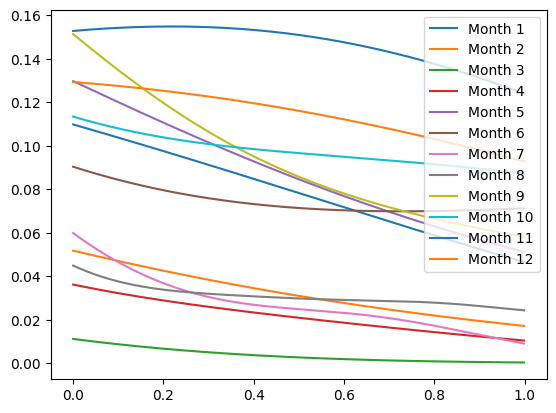

In [263]:
for idx, kde in enumerate(rcms_kde[:, 0, 0]):
    x = np.arange(0, 1, 0.001)
    y = kde.evaluate(x)
    plt.plot(x, y, label=f'Month {idx + 1}')
plt.legend()
plt.show()

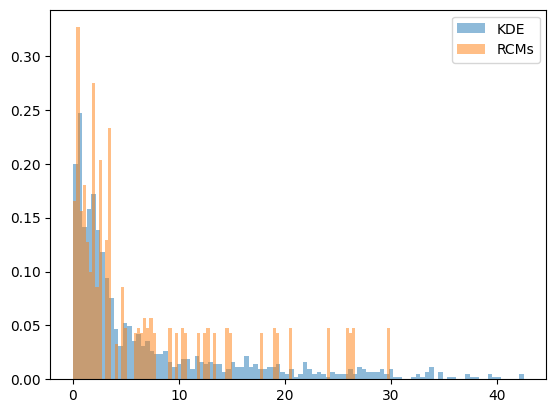

In [264]:
i = 7
j = 5
k = 6

plt.hist(np.exp(rcms_kde[i,j,k].resample(1000)).reshape(-1)-epsilon, bins=100, alpha=0.5, label='KDE', density=True)
plt.hist(np.exp(data[i,j,k,:])-epsilon, bins=100, alpha=0.5, label='RCMs', density=True)
plt.legend()
plt.show()

### APHRODITE

In [11]:
# df = pd.read_csv(files[0])
df = pd.read_csv('/data/hpcdata/users/kenzi22/bcm4rcm/data/aphro_grid.csv')

In [46]:
len(df.lat.unique()), len(df.lon.unique())

(60, 80)

In [4]:
# PATH = "/Users/marron31/repos/bcm4rcm/data/APHRODITE/aphrodite_hma_1951_2016.nc"
PATH = '/data/hpcdata/users/kenzi22/data/APHRODITE/aphrodite_hma_1951_2016.nc'
ds = xr.open_dataset(PATH)

In [21]:
# select data for  period 1961-1975 and spatial extent of interest
# ds_sel = ds.sel(time=slice('1961-01-01', '1975-12-31')).sel(lat=slice(20, 40), lon=slice(60, 105))
ds_sel = ds.sel(time=slice('1961-01-01', '1975-12-31')).sel(lat=slice(df.lat.min(), df.lat.max()), 
                                                            lon=slice(df.lon.min(), df.lon.max())
                                                           )

In [26]:
# Interpolate original dataset to the new coordinates
# interpolated_ds = ds_sel.interp(lat=df.lat.unique(), lon=df.lon.unique(), method='linear', kwargs={"fill_value": "extrapolate"})
interpolated_ds = ds_sel.interp(
    lat=df.lat.unique(),
    lon=df.lon.unique(),
    method='linear',
    kwargs={"bounds_error": True}
)

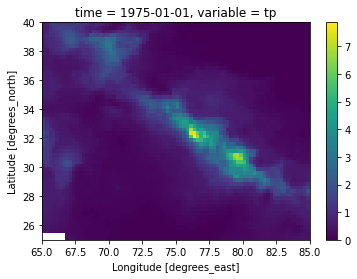

In [28]:
interpolated_ds.sel(time='1975-01-01').to_array().plot()
plt.show()

In [31]:
aphro = interpolated_ds.to_array()

In [45]:
aphro.isel(time=1)

<xarray.DataArray (variable: 1, lat: 60, lon: 80)> Size: 38kB
array([[[       nan,        nan,        nan, ..., 0.50893581,
         0.59540319, 0.68241507],
        [       nan,        nan,        nan, ..., 0.52458662,
         0.63035256, 0.76375282],
        [0.78973228, 0.78440028, 0.80198419, ..., 0.60324079,
         0.53553349, 0.56530809],
        ...,
        [0.35603452, 0.49472386, 0.57554525, ..., 0.0181678 ,
         0.01003229, 0.00553378],
        [0.28219444, 0.30866888, 0.46471119, ..., 0.01950181,
         0.01501205, 0.00859957],
        [0.22427694, 0.29759842, 0.44534722, ..., 0.02059976,
         0.01695035, 0.01607476]]])
Coordinates:
    time      datetime64[ns] 8B 1961-02-01
  * lat       (lat) float64 480B 25.12 25.38 25.62 25.88 ... 39.38 39.62 39.88
  * lon       (lon) float64 640B 65.12 65.38 65.62 65.88 ... 84.38 84.62 84.88
  * variable  (variable) object 8B 'tp'

In [275]:
# Step 1: Extract month and year from the 'time' dimension
interpolated_ds['month'] = interpolated_ds['time'].dt.month


In [276]:
tp = np.array(aphro[0,...])
aprho_months = np.array(aphro[1,...])

for month in range(1, 13):
    # Find indices where the second array equals the current month
    indices = np.where(aprho_months == month, 1, np.NaN)
    to_keep = ~np.all(np.isnan(np.multiply(tp,indices)[...]), axis=(1,2))
    filtered_tp = tp[to_keep,...]
    if month == 1:
        filtered_tp_all = filtered_tp
    elif month == 2:
        # print(filtered_tp_all.shape, filtered_tp.shape)
        filtered_tp_all = np.stack((filtered_tp_all, filtered_tp), axis=0)
    else:
        # print(filtered_tp_all.shape, filtered_tp.shape)
        filtered_tp_all = np.concatenate((filtered_tp_all, np.expand_dims(filtered_tp, axis=0)), axis=0)
    

In [277]:
# Transpose the array to have the dimensions in the order (month, lat, lon, year)
aprho = filtered_tp_all.transpose(0, 3, 2, 1)

In [278]:
# Replace NaNs with zeros - for stability in the KDE computation but to be reviewed
aphro_no_nans = np.nan_to_num(aprho, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

In [279]:
# Apply the log transformation
log_aphro = log_transform(aphro_no_nans, epsilon=1e-5)

In [280]:
aphros_kde = compute_kde(log_aphro)

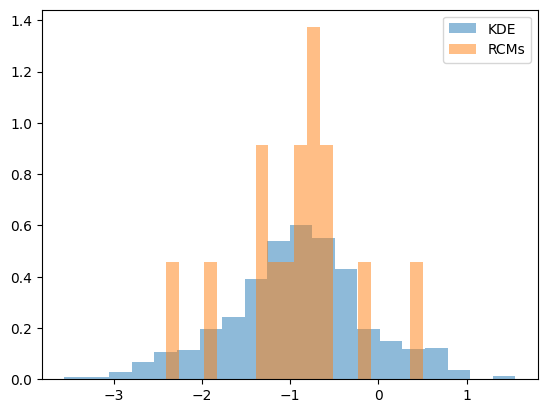

In [281]:
i = 7
j = 30
k = 30

plt.hist(aphros_kde[i,j,k].resample(1000).reshape(-1), bins=20, alpha=0.5, label='KDE', density=True)
plt.hist(log_aphro[i,j,k,:], bins=20, alpha=0.5, label='RCMs', density=True)
plt.legend()
plt.show()

In [285]:
aphros_kde.shape, rcms_kde.shape

((12, 90, 40), (12, 90, 40))

In [288]:
flat_aphros_kde = aphros_kde.reshape(-1)
flat_rcms_kde = rcms_kde.reshape(-1)

In [289]:
from scipy.stats import ks_2samp

In [291]:
def compute_ks_tests(array1, array2):
    assert array1.shape == array2.shape, "Arrays must have the same shape."
    n, m, h = array1.shape
    
    # Initialize an array to store the KS test results (D statistic and p-value for each pair)
    ks_results = np.empty((n, m, h), dtype=[('D', 'f4'), ('p', 'f4')])
    
    for i in range(n):
        for j in range(m):
            for k in range(h):
                # Sample from the KDEs represented by the current cell in each array
                samples1 = sample_from_kde(array1[i, j, k])
                samples2 = sample_from_kde(array2[i, j, k])
                
                # Perform KS test between the two sets of samples
                D, p = ks_2samp(samples1, samples2)
                
                # Store the KS test results
                ks_results[i, j, k] = (D, p)

                print(f'KS test results for cell ({i}, {j}, {k}): D = {D:.4f}, p = {p:.4f}')
    
    return ks_results

def sample_from_kde(kde, n_samples=100, epsilon=1e-5):
    return np.exp(kde.resample(n_samples)).reshape(-1)-epsilon

In [293]:
ks_results = compute_ks_tests(aphros_kde, rcms_kde)

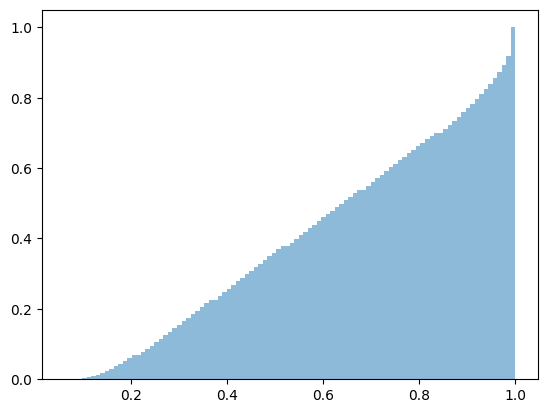

In [318]:
# Apply log transformation: ['MPI', 'CSIRO', 'MPI-REMO2009', 'NOAA', 'MIROC']
log_CSIRO = log_transform(rcm_dict['CSIRO'], epsilon=1e-5)
log_MPI = log_transform(rcm_dict['MPI'], epsilon=1e-5)
log_MPI_REMO2009 = log_transform(rcm_dict['MPI-REMO2009'], epsilon=1e-5)
log_NOAA = log_transform(rcm_dict['NOAA'], epsilon=1e-5)
log_MIROC = log_transform(rcm_dict['MIROC'], epsilon=1e-5)

In [319]:
# KDE computation
kde_CSIRO = compute_kde(log_CSIRO)
kde_MPI = compute_kde(log_MPI)
kde_MPI_REMO2009 = compute_kde(log_MPI_REMO2009)
kde_NOAA = compute_kde(log_NOAA)
kde_MIROC = compute_kde(log_MIROC)

In [320]:
# KS test
ks_results_CSIRO = compute_ks_tests(aphros_kde, kde_CSIRO)
print('Done with CSIRO')
ks_results_MPI = compute_ks_tests(aphros_kde, kde_MPI)
print('Done with MPI')
ks_results_MPI_REMO2009 = compute_ks_tests(aphros_kde, kde_MPI_REMO2009)
print('Done with MPI-REMO2009')
ks_results_NOAA = compute_ks_tests(aphros_kde, kde_NOAA)
print('Done with NOAA')
ks_results_MIROC = compute_ks_tests(aphros_kde, kde_MIROC)
print('Done with MIROC')

Done with CSIRO
Done with MPI
Done with MPI-REMO2009
Done with NOAA
Done with MIROC


In [403]:
ks_results_new = compute_ks_tests(aphros_kde, kde_results)

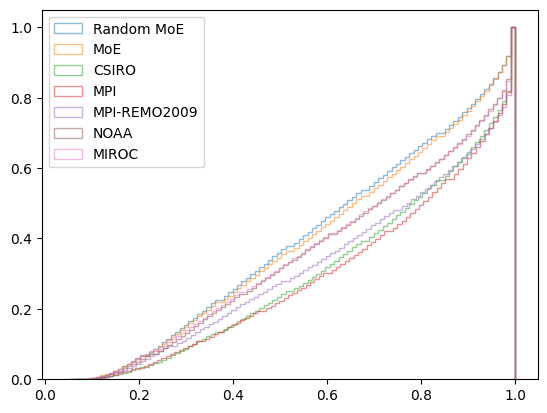

In [404]:
# histograms with no fill
plt.hist(ks_results['D'].reshape(-1), bins=100, cumulative=True, density=True, alpha=0.5, label='Random MoE', histtype='step')
plt.hist(ks_results_new['D'].reshape(-1), bins=100, cumulative=True, density=True, alpha=0.5, label='MoE', histtype='step')
plt.hist(ks_results_CSIRO['D'].reshape(-1), bins=100, cumulative=True, density=True, alpha=0.5, label='CSIRO', histtype='step')
plt.hist(ks_results_MPI['D'].reshape(-1), bins=100, cumulative=True, density=True, alpha=0.5, label='MPI', histtype='step')
plt.hist(ks_results_MPI_REMO2009['D'].reshape(-1), bins=100, cumulative=True, density=True, alpha=0.5, label='MPI-REMO2009', histtype='step')
plt.hist(ks_results_NOAA['D'].reshape(-1), bins=100, cumulative=True, density=True, alpha=0.5, label='NOAA', histtype='step')
plt.hist(ks_results_MIROC['D'].reshape(-1), bins=100, cumulative=True, density=True, alpha=0.5, label='MIROC', histtype='step')

plt.legend()
plt.show()